In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
from tqdm.notebook import tqdm, trange
from copy import deepcopy
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import CoxTimeVaryingFitter

# own imports
from src.utils import create_nfl_field
from src.utils import load_data
from src.utils import life_expectancy

np.set_printoptions(precision=4)
pd.set_option("display.precision", 4)

In [2]:
games, plays, players, scouting, plays_with_collapse, off_cols, def_cols = (
        load_data()
    )
players_with_collapse = pd.merge(
        scouting[scouting.pff_role.isin(["Pass", "Pass Rush", "Pass Block"])][
            ["gameId", "playId", "nflId", "pff_role"]
        ],
        plays_with_collapse,
        how="right",
        on=["gameId", "playId"],
    )


100%|██████████| 8557/8557 [00:01<00:00, 4773.76it/s]


timed_pocketsizes.shape=(8557, 10)


In [3]:

off_team_cols = [
        "possessionTeam_ATL",
        "possessionTeam_BAL",
        "possessionTeam_BUF",
        "possessionTeam_CAR",
        "possessionTeam_CHI",
        "possessionTeam_CIN",
        "possessionTeam_CLE",
        "possessionTeam_DAL",
        "possessionTeam_DEN",
        "possessionTeam_DET",
        "possessionTeam_GB",
        "possessionTeam_HOU",
        "possessionTeam_IND",
        "possessionTeam_JAX",
        "possessionTeam_KC",
        "possessionTeam_LA",
        "possessionTeam_LAC",
        "possessionTeam_LV",
        "possessionTeam_MIA",
        "possessionTeam_MIN",
        "possessionTeam_NE",
        "possessionTeam_NO",
        "possessionTeam_NYG",
        "possessionTeam_NYJ",
        "possessionTeam_PHI",
        "possessionTeam_PIT",
        "possessionTeam_SEA",
        "possessionTeam_SF",
        "possessionTeam_TB",
        "possessionTeam_TEN",
        "possessionTeam_WAS",
    ]

def_team_cols = [
        "defensiveTeam_ATL",
        "defensiveTeam_BAL",
        "defensiveTeam_BUF",
        "defensiveTeam_CAR",
        "defensiveTeam_CHI",
        "defensiveTeam_CIN",
        "defensiveTeam_CLE",
        "defensiveTeam_DAL",
        "defensiveTeam_DEN",
        "defensiveTeam_DET",
        "defensiveTeam_GB",
        "defensiveTeam_HOU",
        "defensiveTeam_IND",
        "defensiveTeam_JAX",
        "defensiveTeam_KC",
        "defensiveTeam_LA",
        "defensiveTeam_LAC",
        "defensiveTeam_LV",
        "defensiveTeam_MIA",
        "defensiveTeam_MIN",
        "defensiveTeam_NE",
        "defensiveTeam_NO",
        "defensiveTeam_NYG",
        "defensiveTeam_NYJ",
        "defensiveTeam_PHI",
        "defensiveTeam_PIT",
        "defensiveTeam_SEA",
        "defensiveTeam_SF",
        "defensiveTeam_TB",
        "defensiveTeam_TEN",
        "defensiveTeam_WAS",
    ]

    ## subset of feature columns
base_feat = [
        "yardsToGo",
        "defendersInBox",
        "Cover-0",
        "Cover-1",
        "Cover-2",
        "Cover-6",
        "misc_def",
        "Quarters",  # cover 4
        "2-Man",  # "cover 5"ish
        "pff_playAction",
        "down2",
        "down3",
        "shotgun",
    ]
opt_feat = ["mean_polydists"] + [f"poly_tau_{i}" for i in range(5, 41, 5)]


In [4]:
norm_cols = list(
        set(base_feat + opt_feat).intersection(
            ["mean_polydists", "defendersInBox", "yardsToGo"]
            + [f"poly_tau_{i}" for i in range(5, 41, 5)]
        )
    )

In [5]:
plays_with_collapse["misc_def"] = plays_with_collapse.pff_passCoverage.isin(
        ["Red Zone", "Bracket", "Prevent", "Miscellaneous"]
    )

In [6]:
X = pd.get_dummies(
        plays_with_collapse[base_feat + opt_feat + ["defensiveTeam", "possessionTeam"]],
        columns=["defensiveTeam", "possessionTeam"],
    )
X[["defensiveTeam", "possessionTeam"]] = plays_with_collapse[
        ["defensiveTeam", "possessionTeam"]
    ]

In [7]:
X.head()

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_NYJ,possessionTeam_PHI,possessionTeam_PIT,possessionTeam_SEA,possessionTeam_SF,possessionTeam_TB,possessionTeam_TEN,possessionTeam_WAS,defensiveTeam,possessionTeam
0,2,6.0,False,True,False,False,False,False,False,0,...,False,False,False,False,False,True,False,False,DAL,TB
1,10,6.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL
2,6,6.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL
3,10,6.0,False,False,False,False,False,False,False,1,...,False,False,False,False,False,False,False,False,TB,DAL
4,15,7.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL


In [8]:
# X[norm_cols] = (X[norm_cols] - X[norm_cols].mean()) / X[norm_cols].std()
Y = plays_with_collapse[["survived", "surv_frame", "pass_frame"]]

In [9]:
X["time"] = Y[["surv_frame", "pass_frame"]].min(axis=1)
X["collapse_event"] = (~Y["survived"]) & (Y.surv_frame.le(Y.pass_frame))
X["pass_event"] =  (Y.surv_frame.gt(Y.pass_frame))

In [10]:
Y.shape[0] - ((Y.surv_frame.gt(Y.pass_frame)).sum() + ((~Y["survived"]) & (Y.surv_frame.le(Y.pass_frame))).sum())

np.int64(59)

In [11]:
## at this point, we have a _short_ dataset X,Y
## Now we have to figure out a way of how to build the "correct" full Dataset. 

In [12]:
X.columns

Index(['yardsToGo', 'defendersInBox', 'Cover-0', 'Cover-1', 'Cover-2',
       'Cover-6', 'misc_def', 'Quarters', '2-Man', 'pff_playAction', 'down2',
       'down3', 'shotgun', 'mean_polydists', 'poly_tau_5', 'poly_tau_10',
       'poly_tau_15', 'poly_tau_20', 'poly_tau_25', 'poly_tau_30',
       'poly_tau_35', 'poly_tau_40', 'defensiveTeam_ARI', 'defensiveTeam_ATL',
       'defensiveTeam_BAL', 'defensiveTeam_BUF', 'defensiveTeam_CAR',
       'defensiveTeam_CHI', 'defensiveTeam_CIN', 'defensiveTeam_CLE',
       'defensiveTeam_DAL', 'defensiveTeam_DEN', 'defensiveTeam_DET',
       'defensiveTeam_GB', 'defensiveTeam_HOU', 'defensiveTeam_IND',
       'defensiveTeam_JAX', 'defensiveTeam_KC', 'defensiveTeam_LA',
       'defensiveTeam_LAC', 'defensiveTeam_LV', 'defensiveTeam_MIA',
       'defensiveTeam_MIN', 'defensiveTeam_NE', 'defensiveTeam_NO',
       'defensiveTeam_NYG', 'defensiveTeam_NYJ', 'defensiveTeam_PHI',
       'defensiveTeam_PIT', 'defensiveTeam_SEA', 'defensiveTeam_SF',
       '

In [13]:
X.loc[X.collapse_event == X.pass_event, ['time', 'collapse_event', 'pass_event']]

,time,collapse_event,pass_event
220,29,False,False
733,44,False,False
1041,51,False,False
1116,43,False,False
1192,48,False,False
1254,36,False,False
1314,36,False,False
1374,31,False,False
1423,40,False,False
2086,60,False,False


In [14]:
datapoints = []
for idx in trange(len(X)): 
    d = X.iloc[idx].to_dict()
    for ti in range(5, min(d["time"]+5, 41), 5): 
        start = ti-5
        if (ti < 40) and (ti < d["time"]): 
            stop = ti 
        else: 
            stop = d["time"]
        pocket_size = d[f"poly_tau_{ti}"]
        pass_event = d["pass_event"] & ( d["time"] <= stop) 
        collapse_event = d["collapse_event"] & ( d["time"] <= stop) 
        
        dp = deepcopy(d) 
        dp["id"] = idx
        dp["start"] = start
        dp["stop"] = stop
        dp["pocket_size"] = pocket_size
        dp["pass_event"] = pass_event
        dp["collapse_event"] = collapse_event
        datapoints.append(dp)
    

  0%|          | 0/8204 [00:00<?, ?it/s]

In [15]:
tv_cols = ["id", "start", "stop", "pocket_size"]

In [16]:
tvx = pd.DataFrame(datapoints)

In [17]:
X_train, X_test = train_test_split(tvx.id.unique(), test_size=0.2)

In [18]:
tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+["pass_event", "collapse_event"]].head(10)

,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,pass_event,collapse_event
6,1,0,5,4.4757,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
7,1,5,10,4.0413,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
8,1,10,15,3.6226,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
9,1,15,20,1.6771,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
10,1,20,23,0.0000,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,True
11,2,0,5,4.6620,6,6.0,False,False,False,False,False,False,False,0,True,False,True,False,False
12,2,5,10,4.3643,6,6.0,False,False,False,False,False,False,False,0,True,False,True,False,False
13,2,10,15,4.3089,6,6.0,False,False,False,False,False,False,False,0,True,False,True,False,False
14,2,15,20,3.6297,6,6.0,False,False,False,False,False,False,False,0,True,False,True,True,False
15,3,0,5,1.9612,10,6.0,False,False,False,False,False,False,False,1,False,False,False,False,False


In [19]:
col = "pass_event"
pass_ctv = CoxTimeVaryingFitter(penalizer=0.2)
pass_ctv.fit(tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+[col]], id_col="id", event_col=col, start_col="start", stop_col="stop", show_progress=True)
pass_ctv.print_summary()

Iteration 1: norm_delta = 1.29e-01, step_size = 0.9500, log_lik = -27370.29088, newton_decrement = 9.80e+01, seconds_since_start = 0.2
Iteration 2: norm_delta = 7.85e-03, step_size = 0.9500, log_lik = -27271.90813, newton_decrement = 3.76e-01, seconds_since_start = 0.3
Iteration 3: norm_delta = 4.02e-04, step_size = 0.9500, log_lik = -27271.53318, newton_decrement = 9.86e-04, seconds_since_start = 0.4
Iteration 4: norm_delta = 2.12e-05, step_size = 1.0000, log_lik = -27271.53220, newton_decrement = 2.47e-06, seconds_since_start = 0.4
Iteration 5: norm_delta = 7.74e-11, step_size = 1.0000, log_lik = -27271.53220, newton_decrement = 3.86e-17, seconds_since_start = 0.5
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 35598 periods, 6563 subjects, 3484 events>
         event col = 'pass_event'
         penalizer = 0.2
number of subjects = 6563
 number of periods = 35598
  number of events = 3484
partial log-likelihood = -27271.53
  time fit was run = 2026-02-25 08:43:06 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
pocket_size    -0.05      0.96      0.01           -0.06           -0.03                0.94                0.97
yardsToGo      -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
defendersInBox -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
Cover-0         0.14      1.15      0.07            0.01            0.27                1.01                1.31
Cover-1         0.02      1.02      0.02           -0.02            0.07                0.98                1.07
Cover-2        -0.02      0.98      0.03           -0.08            0.03                0.92                1.03
Cover-6        -0.00      1.00      0.03           -0.07            0.06                0.94                1.06
misc_def       -0.09      0.91      0.05           -0.18           -0.01                0.83                0.99
Quarters        0.01      1.01      0.03           -0.05            0.06                0.95                1.07
2-Man          -0.13      0.88      0.06           -0.25           -0.01                0.78                0.99
pff_playAction -0.22      0.80      0.02           -0.27           -0.18                0.77                0.84
down2           0.05      1.05      0.02            0.01            0.09                1.01                1.09
down3          -0.07      0.93      0.02           -0.12           -0.03                0.89                0.97
shotgun         0.00      1.00      0.02           -0.04            0.04                0.96                1.04

                cmp to     z      p  -log2(p)
covariate                                    
pocket_size       0.00 -7.51 <0.005     43.97
yardsToGo         0.00 -2.11   0.04      4.83
defendersInBox    0.00 -0.76   0.44      1.17
Cover-0           0.00  2.07   0.04      4.71
Cover-1           0.00  0.91   0.36      1.47
Cover-2           0.00 -0.85   0.39      1.34
Cover-6           0.00 -0.09   0.92      0.11
misc_def          0.00 -2.09   0.04      4.78
Quarters          0.00  0.18   0.86      0.22
2-Man             0.00 -2.16   0.03      5.02
pff_playAction    0.00 -9.73 <0.005     71.94
down2             0.00  2.24   0.03      5.31
down3             0.00 -3.41 <0.005     10.58
shotgun           0.00  0.03   0.97      0.04
---
Partial AIC = 54571.06
log-likelihood ratio test = 197.52 on 14 df
-log2(p) of ll-ratio test = 112.13

In [20]:
X_test

array([2831, 3410, 5097, ..., 5919, 6682, 6159], shape=(1641,))

In [21]:
tvx.loc[tvx.id.isin([2486])]

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_WAS,defensiveTeam,possessionTeam,time,collapse_event,pass_event,id,start,stop,pocket_size
13413,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,0,5,4.7007
13414,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,5,10,4.0947
13415,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,10,15,3.9046
13416,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,15,20,3.6045
13417,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,True,False,2486,20,24,0.0000


In [22]:
pred = pass_ctv.predict_partial_hazard(tvx.loc[tvx.id.isin([2486]), tv_cols+base_feat+["pass_event"]]).values

In [23]:
pred

array([1.013 , 1.0412, 1.0501, 1.0645, 1.2526])

In [24]:
plot_pred = np.hstack([[pri]*5 for pri in pred])
np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0])

array([1.6005e-04, 3.2017e-04, 6.4070e-04, 1.2671e-03, 1.5809e-03,
       3.5647e-03, 6.3297e-03, 1.3903e-02, 2.4023e-02, 4.2501e-02,
       7.3790e-02, 1.1054e-01, 1.5344e-01, 1.9170e-01, 2.3867e-01,
       2.9829e-01, 3.6303e-01, 4.3737e-01, 5.0073e-01, 5.7976e-01,
       7.7361e-01, 8.7493e-01, 9.7191e-01, 1.0801e+00, 1.1904e+00])

In [25]:
plot_pred

array([1.013 , 1.013 , 1.013 , 1.013 , 1.013 , 1.0412, 1.0412, 1.0412,
       1.0412, 1.0412, 1.0501, 1.0501, 1.0501, 1.0501, 1.0501, 1.0645,
       1.0645, 1.0645, 1.0645, 1.0645, 1.2526, 1.2526, 1.2526, 1.2526,
       1.2526])

In [26]:
pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0]

array([1.5799e-04, 3.1605e-04, 6.3245e-04, 1.2508e-03, 1.5605e-03,
       3.4238e-03, 6.0794e-03, 1.3353e-02, 2.3073e-02, 4.0821e-02,
       7.0267e-02, 1.0527e-01, 1.4612e-01, 1.8255e-01, 2.2727e-01,
       2.8022e-01, 3.4105e-01, 4.1088e-01, 4.7040e-01, 5.4465e-01,
       6.1759e-01, 6.9847e-01, 7.7589e-01, 8.6224e-01, 9.5029e-01])

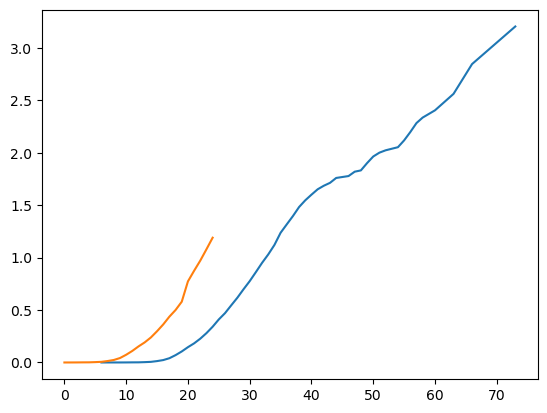

In [27]:
plt.plot(pass_ctv.baseline_cumulative_hazard_, label='baseline_cumulative_hazard')
plt.plot(np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0]), label="basline*partial")

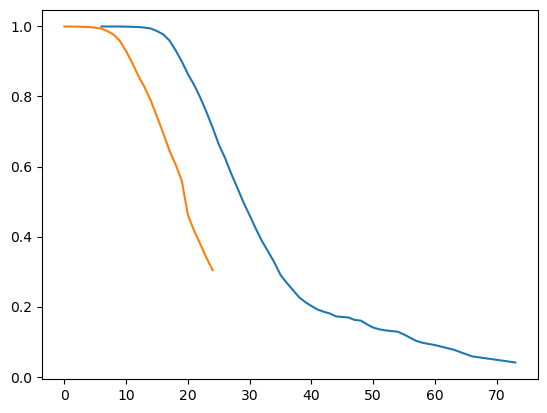

In [28]:
plt.plot(np.exp(-pass_ctv.baseline_cumulative_hazard_), label='baseline_cumulative_survival')
plt.plot(np.exp(-1*np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0])), label="basline*partial")

In [29]:
collapse_ctv = CoxTimeVaryingFitter(penalizer=0.2)
collapse_ctv.fit(tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+["collapse_event"]], id_col="id", event_col="collapse_event", start_col="start", stop_col="stop", show_progress=True)
collapse_ctv.print_summary()

Iteration 1: norm_delta = 3.64e-01, step_size = 0.9500, log_lik = -23649.76073, newton_decrement = 6.96e+02, seconds_since_start = 0.1
Iteration 2: norm_delta = 2.72e-02, step_size = 0.9500, log_lik = -22946.42466, newton_decrement = 3.81e+00, seconds_since_start = 0.1
Iteration 3: norm_delta = 1.43e-03, step_size = 0.9500, log_lik = -22942.62231, newton_decrement = 1.04e-02, seconds_since_start = 0.2
Iteration 4: norm_delta = 7.52e-05, step_size = 1.0000, log_lik = -22942.61193, newton_decrement = 2.62e-05, seconds_since_start = 0.2
Iteration 5: norm_delta = 4.92e-10, step_size = 1.0000, log_lik = -22942.61190, newton_decrement = 1.21e-15, seconds_since_start = 0.3
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 35598 periods, 6563 subjects, 3028 events>
         event col = 'collapse_event'
         penalizer = 0.2
number of subjects = 6563
 number of periods = 35598
  number of events = 3028
partial log-likelihood = -22942.61
  time fit was run = 2026-02-25 08:43:07 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
pocket_size    -0.23      0.80      0.01           -0.24           -0.22                0.79                0.81
yardsToGo      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
defendersInBox  0.02      1.02      0.01           -0.00            0.04                1.00                1.04
Cover-0         0.27      1.31      0.07            0.14            0.40                1.15                1.49
Cover-1         0.01      1.01      0.02           -0.03            0.06                0.97                1.06
Cover-2        -0.04      0.96      0.03           -0.10            0.02                0.91                1.02
Cover-6        -0.03      0.97      0.03           -0.09            0.04                0.91                1.04
misc_def        0.01      1.01      0.05           -0.08            0.10                0.92                1.10
Quarters       -0.03      0.97      0.03           -0.09            0.03                0.92                1.03
2-Man          -0.09      0.91      0.06           -0.21            0.03                0.81                1.03
pff_playAction  0.05      1.05      0.02            0.01            0.10                1.01                1.10
down2          -0.00      1.00      0.02           -0.04            0.04                0.96                1.04
down3           0.04      1.04      0.02           -0.00            0.08                1.00                1.09
shotgun        -0.04      0.96      0.02           -0.08            0.00                0.92                1.00

                cmp to      z      p  -log2(p)
covariate                                     
pocket_size       0.00 -36.70 <0.005    976.84
yardsToGo         0.00  -1.42   0.16      2.68
defendersInBox    0.00   1.67   0.10      3.40
Cover-0           0.00   4.13 <0.005     14.76
Cover-1           0.00   0.60   0.55      0.86
Cover-2           0.00  -1.39   0.16      2.61
Cover-6           0.00  -0.80   0.42      1.25
misc_def          0.00   0.18   0.86      0.22
Quarters          0.00  -0.94   0.34      1.54
2-Man             0.00  -1.48   0.14      2.85
pff_playAction    0.00   2.24   0.03      5.30
down2             0.00  -0.04   0.96      0.05
down3             0.00   1.83   0.07      3.90
shotgun           0.00  -1.90   0.06      4.13
---
Partial AIC = 45913.22
log-likelihood ratio test = 1414.30 on 14 df
-log2(p) of ll-ratio test = 972.88

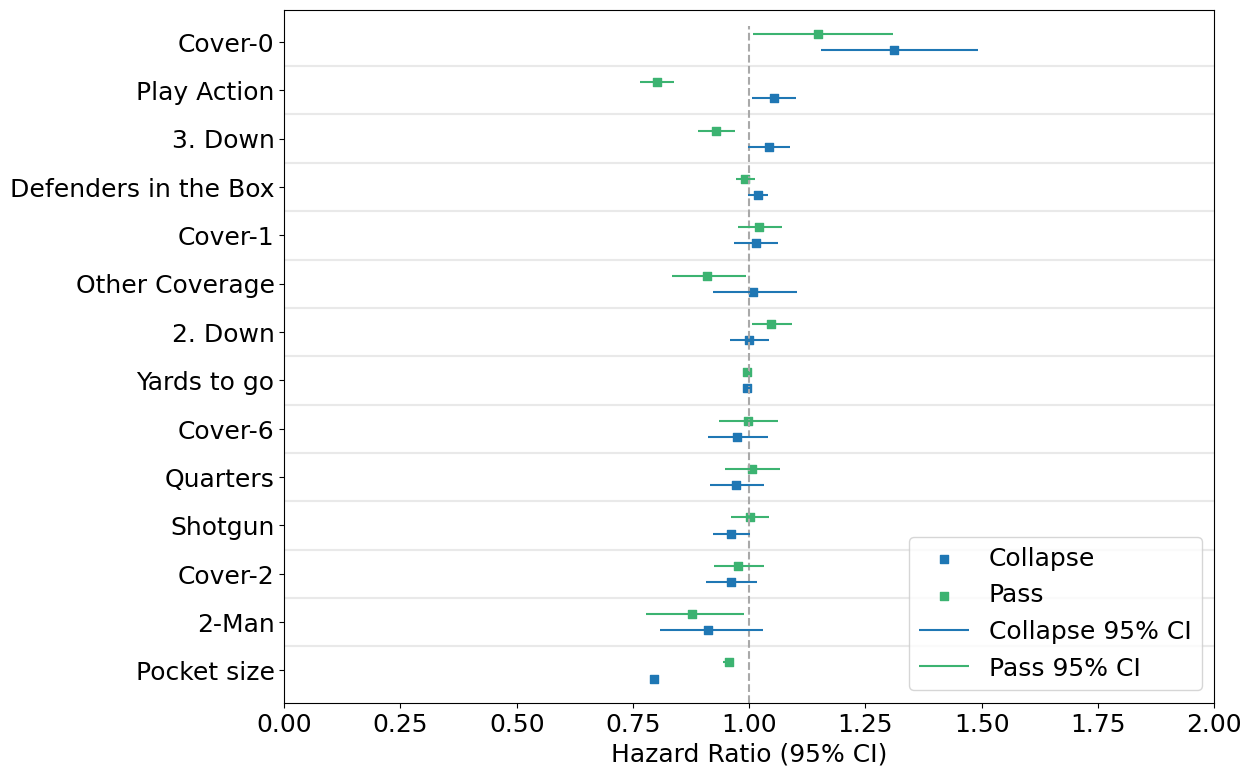

In [30]:
with plt.style.context({"font.size":18}):
    fig, ax = plt.subplots(figsize=(12,9))
    ax.vlines([1.0], ymin=-1, ymax=41, linestyles="--", color="darkgray")
    plt.xlabel("Hazard Ratio (95% CI)")

    yticklabel_dict = {
        "Cover-0":"Cover-0", 
        "Cover-1":"Cover-1", 
        "Cover-2":"Cover-2", 
        "Cover-6":"Cover-6", 
        "Quarters":"Quarters",
        "2-Man":"2-Man",
        "shotgun":"Shotgun", 
        "down3":"3. Down", 
        "down2":"2. Down", 
        "yardsToGo":"Yards to go", 
        "misc_def": "Other Coverage", 
        "pocket_size": "Pocket size", 
        "defendersInBox": "Defenders in the Box", 
        "pff_playAction":"Play Action"
    }

    hr_plot_df = pd.DataFrame({
        "collapse_hr":collapse_ctv.hazard_ratios_,
        "pass_hr":pass_ctv.hazard_ratios_,
        "collapse_lb":np.exp(collapse_ctv.confidence_intervals_["95% lower-bound"]),
        "collapse_ub":np.exp(collapse_ctv.confidence_intervals_["95% upper-bound"]),
        "pass_lb":np.exp(pass_ctv.confidence_intervals_["95% lower-bound"]),
        "pass_ub":np.exp(pass_ctv.confidence_intervals_["95% upper-bound"]),
    }).reset_index().sort_values("collapse_hr")

    y_loc = np.arange(1,43,3)
    hr_plot_df["covariate"] = hr_plot_df["covariate"].map(yticklabel_dict)

    ax.scatter(hr_plot_df["collapse_hr"].values, y_loc-0.5, marker="s", label="Collapse")
    ax.scatter(hr_plot_df["pass_hr"].values, y_loc+0.5, marker="s", color="mediumseagreen", label="Pass")

    ax.hlines(y_loc-0.5, hr_plot_df["collapse_lb"], hr_plot_df["collapse_ub"], label="Collapse 95% CI")
    ax.hlines(y_loc+0.5, hr_plot_df["pass_lb"], hr_plot_df["pass_ub"], label="Pass 95% CI", color="mediumseagreen")
    
    ax.hlines(y_loc[:-1]+1.5, xmin=0.0, xmax=4, color="darkgray", alpha=.25)

    ax.set_yticks(y_loc, hr_plot_df["covariate"].values)
    plt.xlim(0,2)
    plt.ylim(-1,42)
    plt.legend(loc="lower right")
    plt.savefig("time_vary_hr.png", dpi=600)
    plt.show()

## so we now have two models, each of which allows to estimate the hazard conditional on the pocket size
### next step is then to use the hazards to estimate the cumulative incidence conditional on the pocket size
### do we also want to predict / estimate the pocket size pre snap? 

In [31]:
tvx.loc[tvx.id.isin([X_test])]

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_WAS,defensiveTeam,possessionTeam,time,collapse_event,pass_event,id,start,stop,pocket_size


In [32]:
collapse_ctv.predict_partial_hazard(tvx.loc[tvx.id.isin(X_test), tv_cols+base_feat+["collapse_event"]])

0       0.6861
1       0.7047
2       0.8592
3       1.4529
4       1.8122
         ...  
8935    1.0085
8936    1.6963
8937    1.6140
8938    1.8165
8939    1.7301
Length: 8940, dtype: float64

In [33]:
pass_ctv.predict_partial_hazard(tvx.loc[tvx.id.isin(X_test), tv_cols+base_feat+["pass_event"]])

0       0.9670
1       0.9721
2       1.0109
3       1.1213
4       1.1713
         ...  
8935    1.1208
8936    1.2419
8937    1.2298
8938    1.2588
8939    1.2467
Length: 8940, dtype: float64

In [34]:
hdf = pd.concat([
    pd.Series(np.arange(100), name="t"), 
    collapse_ctv.baseline_survival_.rename(columns={"baseline survival":"baseline_collapse_survival"}), 
    collapse_ctv.baseline_cumulative_hazard_.rename(columns={"baseline hazard":"baseline_collapse_cum_hazard"}),
    pass_ctv.baseline_survival_.rename(columns={"baseline survival":"baseline_pass_survival"}), 
    pass_ctv.baseline_cumulative_hazard_.rename(columns={"baseline hazard":"baseline_pass_cum_hazard"})
    ], axis=1)

hdf['baseline_collapse_survival'] = hdf['baseline_collapse_survival'].ffill().fillna(1.0)
hdf['baseline_collapse_cum_hazard'] = hdf['baseline_collapse_cum_hazard'].ffill().fillna(0.0)

hdf['baseline_pass_survival'] = hdf['baseline_pass_survival'].ffill().fillna(1.0)
hdf['baseline_pass_cum_hazard'] = hdf['baseline_pass_cum_hazard'].ffill().fillna(0.0)

hdf['baseline_collapse_hazard'] = hdf['baseline_collapse_cum_hazard'].diff().fillna(0.0)
hdf['baseline_pass_hazard'] = hdf['baseline_pass_cum_hazard'].diff().fillna(0.0)
hdf.head(15)


,t,baseline_collapse_survival,baseline_collapse_cum_hazard,baseline_pass_survival,baseline_pass_cum_hazard,baseline_collapse_hazard,baseline_pass_hazard
0,0,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
1,1,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
2,2,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
3,3,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
4,4,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
5,5,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
6,6,0.9998,0.0002,0.9998,0.0002,0.0002,0.0002
7,7,0.9996,0.0004,0.9998,0.0002,0.0002,0.0000
8,8,0.9996,0.0004,0.9998,0.0002,0.0000,0.0000
9,9,0.9989,0.0011,0.9997,0.0003,0.0007,0.0002


<Axes: >

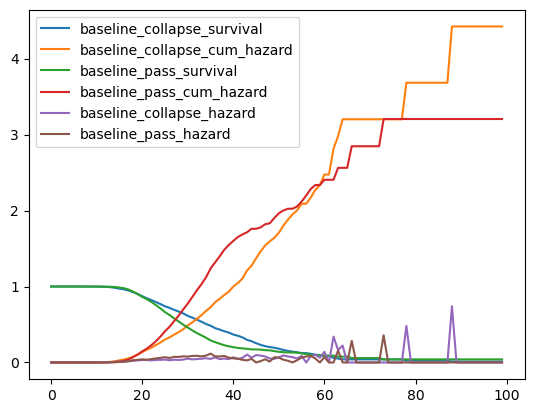

In [35]:
hdf.drop(columns=["t"]).plot()

In [36]:
pass_calib = [[] for _ in range(100)]
total_passes = 0

collapse_calib = [[] for _ in range(100)]
total_collapses = 0

for test_id in tqdm(X_train): 
    input_df = tvx.loc[tvx.id==test_id, tv_cols+base_feat+["collapse_event", "pass_event"]]
    
    pred_partial_hazard_collapse = collapse_ctv.predict_partial_hazard(input_df)
    pred_partial_hazard_collapse.index = input_df.stop

    pred_partial_hazard_pass = pass_ctv.predict_partial_hazard(input_df)
    pred_partial_hazard_pass.index = input_df.stop

    df = pd.concat([
        hdf["baseline_collapse_hazard"], 
        pred_partial_hazard_collapse.rename("partial_collapse_hazard"),
        hdf["baseline_pass_hazard"], 
        pred_partial_hazard_pass.rename("partial_pass_hazard")
        ],axis=1)

    df["partial_collapse_hazard"] = df["partial_collapse_hazard"].bfill()
    df["collapse_hazard"] = df["partial_collapse_hazard"]*df["baseline_collapse_hazard"]
    df["cum_collapse_hazard"] = df["collapse_hazard"].cumsum()

    df["partial_pass_hazard"] = df["partial_pass_hazard"].bfill()
    df["pass_hazard"] = df["partial_pass_hazard"]*df["baseline_pass_hazard"]
    df["cum_pass_hazard"] = df["pass_hazard"].cumsum()
    
    df["pp"] = 1 - np.exp(-df["pass_hazard"])
    df["pc"] = 1 - np.exp(-df["collapse_hazard"])
    
    stop_time = input_df["stop"].max()
    for vh in df.collapse_hazard.head(stop_time).values: 
        collapse_calib[min(int(vh*100), 99)].append(0)
    for vh in df.pass_hazard.head(stop_time).values: 
        pass_calib[min(int(vh*100), 99)].append(0)
    
    chzd = df[["pc", "cum_collapse_hazard"]].iloc[stop_time].to_dict()
    phzd = df[["pp", "cum_pass_hazard"]].iloc[stop_time].to_dict()

    if input_df["collapse_event"].max(): 
        collapse_calib[min(int(chzd["pc"]*100), 99)].append(1) 
        total_collapses += 1      

    if input_df["pass_event"].max(): 
        pass_calib[min(int(phzd["pp"]*100), 99)].append(1)        
        total_passes += 1
    
    # print(stop_time, collapse_happened, pass_happened)
    # print("collapse hazard@stop: ", df[["collapse_hazard", "cum_collapse_hazard"]].iloc[stop_time].to_dict())
    # does this mean, 2.93 % of times this should have collapsed here / 0.0666 percent should have died until this step? 




    # pred_partial_hazard_pass = pass_ctv.predict_partial_hazard(tvx.loc[tvx.id==test_id, tv_cols+base_feat+["pass_event"]])
    # partial hazard is grouped in 5s. 

  0%|          | 0/6563 [00:00<?, ?it/s]

In [37]:
input_df


,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,collapse_event,pass_event
13002,2415,0,5,5.3177,5,6.0,False,False,False,False,False,True,False,0,False,True,True,False,False
13003,2415,5,10,5.4308,5,6.0,False,False,False,False,False,True,False,0,False,True,True,False,False
13004,2415,10,15,5.5839,5,6.0,False,False,False,False,False,True,False,0,False,True,True,False,False
13005,2415,15,20,0.5770,5,6.0,False,False,False,False,False,True,False,0,False,True,True,False,False
13006,2415,20,24,0.0000,5,6.0,False,False,False,False,False,True,False,0,False,True,True,True,False


c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


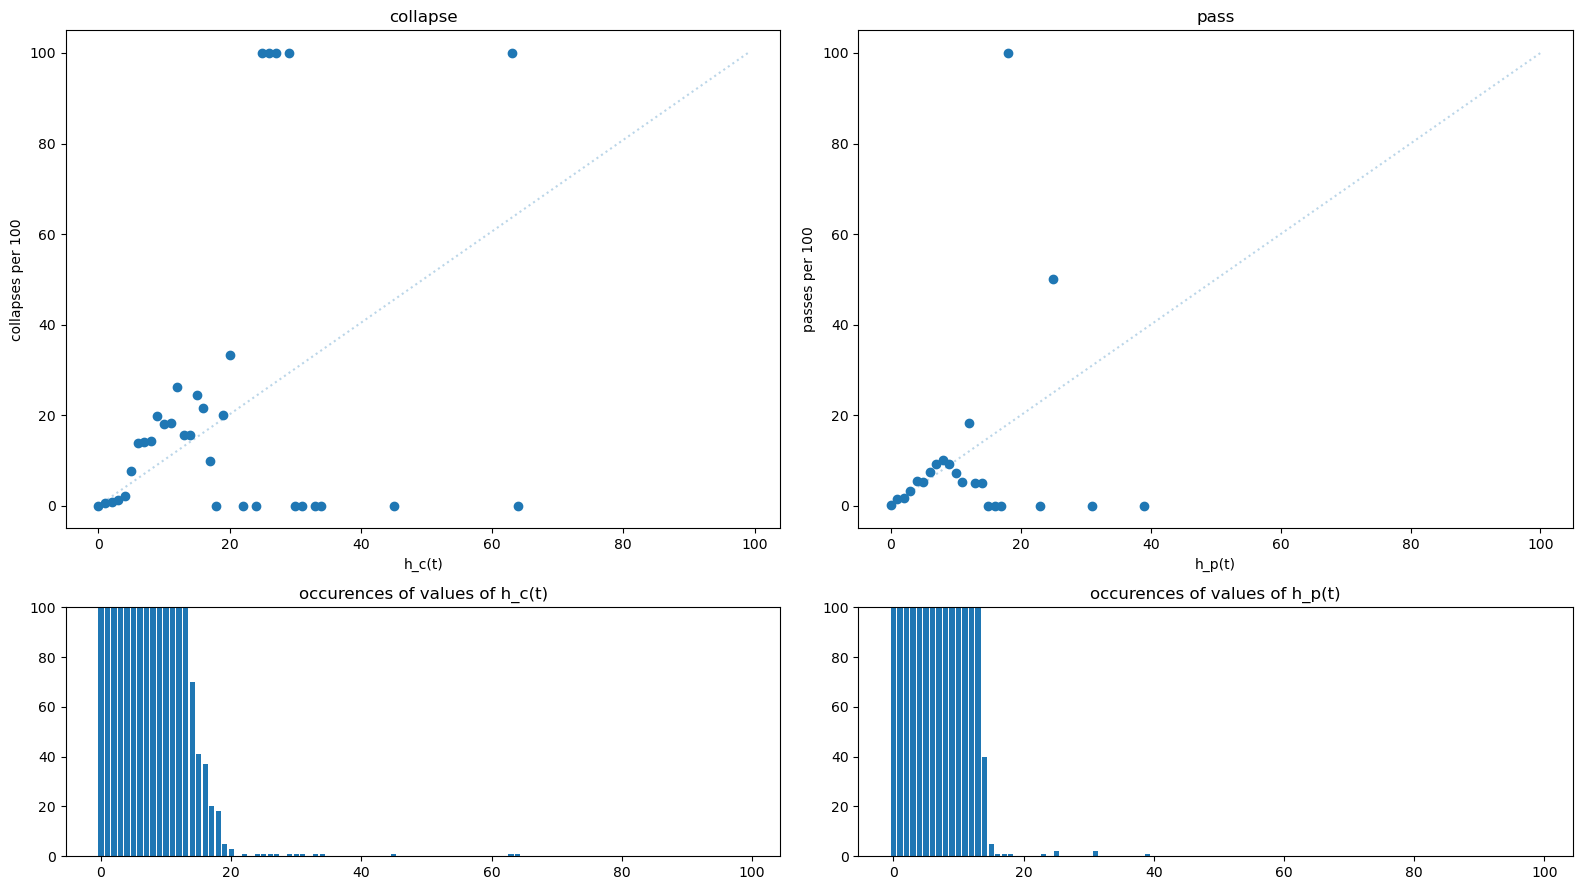

In [38]:
fig, ax = plt.subplots(2,2, figsize=(16,9), height_ratios=(2,1))
ax[0,0].plot([0,99], [0,100], alpha=.3, linestyle=":")
ax[0,0].scatter(np.arange(100),[np.mean(bucket)*100 for bucket in collapse_calib])
ax[0,0].set_title("collapse")
ax[0,0].set_xlabel("h_c(t)")
ax[0,0].set_ylabel("collapses per 100")
ax[0,1].plot([0,100], [0,100], alpha=.3, linestyle=":")
ax[0,1].scatter(np.arange(100),[np.mean(bucket)*100 for bucket in pass_calib])
ax[0,1].set_xlabel("h_p(t)")
ax[0,1].set_ylabel("passes per 100")
ax[0,1].set_title("pass")
ax[1,0].bar(np.arange(100), [len(bucket) for bucket in collapse_calib])
ax[1,0].set_title("occurences of values of h_c(t)")
ax[1,1].bar(np.arange(100), [len(bucket) for bucket in pass_calib])
ax[1,1].set_title("occurences of values of h_p(t)")
fig.tight_layout()
ax[1,0].set_ylim(0,100)
ax[1,1].set_ylim(0,100)
plt.show()


<Axes: >

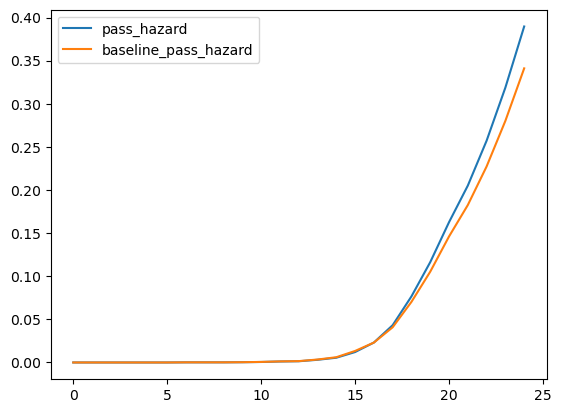

In [39]:
df[["pass_hazard", "baseline_pass_hazard"]].cumsum().head(25).plot()

In [40]:
# we have df in 5er buckets. we have collapse event bool, we have event timing. so> how large was hazard before shit hit the fan? 

In [41]:
tvx.loc[(tvx.start.eq(20)), tv_cols+base_feat+["collapse_event", "pass_event"]]

,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,collapse_event,pass_event
4,0,20,25,0.5810,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
10,1,20,23,0.0000,10,6.0,False,False,False,False,False,False,False,0,False,False,False,True,False
19,3,20,25,1.1385,10,6.0,False,False,False,False,False,False,False,1,False,False,False,False,False
37,7,20,25,0.9338,10,6.0,False,False,False,True,False,False,False,0,True,False,True,False,True
42,8,20,25,1.4281,10,6.0,False,False,False,False,False,False,False,0,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44506,8198,20,25,3.4918,20,4.0,False,False,True,False,False,False,False,0,True,False,True,False,False
44513,8199,20,25,3.3290,15,4.0,False,False,True,False,False,False,False,0,True,False,True,False,True
44518,8200,20,25,1.4342,8,4.0,False,False,False,False,True,False,False,0,False,True,True,False,False
44530,8202,20,25,0.5840,7,6.0,False,False,True,False,False,False,False,0,True,False,True,False,False


In [93]:

tl_min = 20
tl_max = 21

In [186]:
input_df

,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,collapse_event,pass_event
13002,2415,0,5,5.3177,5,6.0,False,False,False,False,False,True,False,0,False,True,True,False,False
13003,2415,5,10,5.4308,5,6.0,False,False,False,False,False,True,False,0,False,True,True,False,False
13004,2415,10,15,5.5839,5,6.0,False,False,False,False,False,True,False,0,False,True,True,False,False
13005,2415,15,20,0.5770,5,6.0,False,False,False,False,False,True,False,0,False,True,True,False,False
13006,2415,20,24,0.0000,5,6.0,False,False,False,False,False,True,False,0,False,True,True,True,False


In [190]:
pred_list = []

tl_min = 20
tl_max = 21

for tau_landmark in range(tl_min,tl_max,5): 
    tau_window_size = 5
    total_passes = 0
    
    total_collapses = 0
    total_neither = 0


    for test_id in tqdm(X_train): 
        input_df2 = tvx.loc[(tvx.id==test_id) & (tvx.start.between(tau_landmark, tau_landmark+tau_window_size-1)), tv_cols+base_feat+["collapse_event", "pass_event"]]
        if len(input_df2) < 1: 
            continue
        input_df = tvx.loc[(tvx.id==test_id) & (tvx.start.between(0, tau_landmark+tau_window_size-1)), tv_cols+base_feat+["collapse_event", "pass_event"]].copy()
        input_df["end_time"] = input_df["stop"].copy()
        
        
        input_df["stop"] = 25
        pred_partial_hazard_collapse = collapse_ctv.predict_partial_hazard(input_df.drop(columns=["pass_event"]))
        pred_partial_hazard_collapse.index = input_df.end_time

        pred_partial_hazard_pass = pass_ctv.predict_partial_hazard(input_df.drop(columns=["collapse_event"]))
        pred_partial_hazard_pass.index = input_df.end_time

        df = pd.concat([
            hdf["baseline_collapse_hazard"], 
            pred_partial_hazard_collapse.rename("partial_collapse_hazard"),
            hdf["baseline_pass_hazard"], 
            pred_partial_hazard_pass.rename("partial_pass_hazard")
            ],axis=1)
        
        stop_time = input_df["stop"].max()
        
        # two ways of fixing missing time: a) use only partial hazard b) keep measurement constant. 
        #compute hazards
        df["partial_collapse_hazard"] = df["partial_collapse_hazard"].ffill().fillna(0.0)
        # df["partial_collapse_hazard"] = df["partial_collapse_hazard"].fillna(1.0) # fill it with 1, so that the baseline hazard is used exclusively
        df["collapse_hazard"] = df["partial_collapse_hazard"] * df["baseline_collapse_hazard"]
        df["cum_collapse_hazard"] = df["collapse_hazard"].cumsum()

        df["partial_pass_hazard"] = df["partial_pass_hazard"].ffill().fillna(0.0)
        # df["partial_pass_hazard"] = df["partial_pass_hazard"].fillna(1.0) # fill it with 1, so that the baseline hazard is used exclusively
        df["pass_hazard"] = df["partial_pass_hazard"] * df["baseline_pass_hazard"]
        df["cum_pass_hazard"] = df["pass_hazard"].cumsum()
        
        
        df["cum_hazard_agg"] = df["cum_pass_hazard"] + df["cum_collapse_hazard"]
        df["hazard_agg"] = df["pass_hazard"] + df["collapse_hazard"]
        df.loc[:tau_landmark, "hazard_agg"] = 0.0 # set hazard to zero before landmark  
        df["cond_cum_hazard_agg"] = df["hazard_agg"].cumsum() # this should naturally lead to a hazard of 0 and therefore a survival of 1 up until the landmark 
        
        df["agg_survival"] = np.exp(-(df["cond_cum_hazard_agg"] ).shift(periods=1, fill_value=1.0))
        df["p_agg"] = 1-np.exp(-df["hazard_agg"])
        
        df["split_collapse"] = df["collapse_hazard"] / (df["hazard_agg"]+1e-9)
        df["split_pass"] = df["pass_hazard"] / (df["hazard_agg"]+1e-9)
                
        # cif_stuff? 
        
        df["i_c"] = df["agg_survival"] * df["p_agg"] * df["split_collapse"] # cause specific incidence
        df["i_p"] = df["agg_survival"] * df["p_agg"] * df["split_pass"] # cause specific incidence
        
        # surv = (1 - cif_p - cif_c)
        
        # add 1 if collapsed        
        preds = df.iloc[tau_landmark:tau_landmark+tau_window_size][["i_c", "i_p"]].sum().to_dict()
        preds["survived"] = df["agg_survival"].iat[tau_landmark+tau_window_size]
        preds["id"] = test_id
        preds["tau_landmark"] = tau_landmark
        preds["collapse"] = input_df["collapse_event"].max()
        preds["pass"] = input_df["pass_event"].max()
        preds["steps"] = 5
        pred_list.append(preds)
        
        agg_outcomes = preds["i_c"] + preds["i_p"] + preds["survived"]
        for f in ["i_c", "i_p", "survived"]:
            preds[f] = preds[f]/agg_outcomes
        
        # the fact that the survival is also scuffed suggests, that the pass hazard may be somehow wrong. 
        surv = df["agg_survival"].iat[tau_landmark+tau_window_size] - df["agg_survival"].iat[tau_landmark]
        surv_idx = min(int(surv*100), 99)//bucket_size
        
        
        
        cif_surv = 1 - preds["i_c"] - preds["i_p"]
        cif_surv_idx = min(int(cif_surv*100), 99)//bucket_size
        
        if input_df["collapse_event"].max() and input_df["pass_event"].max(): 
            print("both should not be happening")
              
        elif input_df["collapse_event"].max(): # collapse occured
            total_collapses += 1
            
        elif input_df["pass_event"].max(): # pass occured
            total_passes += 1
            
        else: # neither occured
            total_neither += 1
        
        
    calib_cifc_dict[tau_landmark] = cifc_calib
    calib_cifp_dict[tau_landmark] = cifp_calib
    calib_cif_surv_dict[tau_landmark] = cif_surv_calib
    print(f"{total_collapses=}, {total_passes=}, {total_neither=}")

  0%|          | 0/6563 [00:00<?, ?it/s]

total_collapses=880, total_passes=1081, total_neither=2837


In [191]:
df.iloc[stop_time -5: stop_time + 5]

,baseline_collapse_hazard,partial_collapse_hazard,baseline_pass_hazard,partial_pass_hazard,collapse_hazard,cum_collapse_hazard,pass_hazard,cum_pass_hazard,cum_hazard_agg,hazard_agg,cond_cum_hazard_agg,agg_survival,p_agg,split_collapse,split_pass,i_c,i_p
20,0.0324,1.7184,0.0408,1.1342,0.0557,0.1129,0.0463,0.1416,0.2545,0.0000,0.0000,1.0000,0.0000,5.5726e+07,4.6331e+07,0.0000,0.0000
21,0.0318,1.7184,0.0364,1.1342,0.0547,0.1676,0.0413,0.1829,0.3505,0.0960,0.0960,1.0000,0.0916,5.6967e-01,4.3033e-01,0.0522,0.0394
22,0.0275,1.7184,0.0447,1.1342,0.0472,0.2148,0.0507,0.2337,0.4484,0.0979,0.1939,0.9084,0.0933,4.8194e-01,5.1806e-01,0.0408,0.0439
23,0.0329,1.7184,0.0530,1.1342,0.0565,0.2713,0.0601,0.2937,0.5650,0.1166,0.3105,0.8237,0.1100,4.8486e-01,5.1514e-01,0.0440,0.0467
24,0.0348,1.9609,0.0608,1.1642,0.0683,0.3396,0.0708,0.3645,0.7042,0.1391,0.4497,0.7331,0.1299,4.9108e-01,5.0892e-01,0.0468,0.0485
25,0.0383,1.9609,0.0698,1.1642,0.0751,0.4147,0.0813,0.4458,0.8605,0.1564,0.6060,0.6378,0.1447,4.8004e-01,5.1996e-01,0.0443,0.0480
26,0.0288,1.9609,0.0595,1.1642,0.0564,0.4711,0.0693,0.5151,0.9862,0.1257,0.7317,0.5455,0.1181,4.4878e-01,5.5122e-01,0.0289,0.0355
27,0.0366,1.9609,0.0742,1.1642,0.0717,0.5428,0.0864,0.6016,1.1444,0.1582,0.8899,0.4811,0.1463,4.5345e-01,5.4655e-01,0.0319,0.0385
28,0.0328,1.9609,0.0729,1.1642,0.0643,0.6071,0.0849,0.6865,1.2936,0.1492,1.0391,0.4107,0.1386,4.3086e-01,5.6914e-01,0.0245,0.0324
29,0.0380,1.9609,0.0809,1.1642,0.0745,0.6816,0.0942,0.7806,1.4622,0.1687,1.2078,0.3538,0.1552,4.4172e-01,5.5828e-01,0.0243,0.0307


In [192]:
df.iloc[15:25]

,baseline_collapse_hazard,partial_collapse_hazard,baseline_pass_hazard,partial_pass_hazard,collapse_hazard,cum_collapse_hazard,pass_hazard,cum_pass_hazard,cum_hazard_agg,hazard_agg,cond_cum_hazard_agg,agg_survival,p_agg,split_collapse,split_pass,i_c,i_p
15,0.0114,0.5464,0.0073,0.9047,0.0063,0.0159,0.0066,0.0121,0.0280,0.0000,0.0000,1.0000,0.0000,6.2559e+06,6.5807e+06,0.0000,0.0000
16,0.0098,0.5464,0.0097,0.9047,0.0054,0.0212,0.0088,0.0209,0.0422,0.0000,0.0000,1.0000,0.0000,5.3775e+06,8.7933e+06,0.0000,0.0000
17,0.0165,0.5464,0.0177,0.9047,0.0090,0.0303,0.0161,0.0370,0.0672,0.0000,0.0000,1.0000,0.0000,9.0147e+06,1.6056e+07,0.0000,0.0000
18,0.0215,0.5464,0.0294,0.9047,0.0118,0.0420,0.0266,0.0636,0.1056,0.0000,0.0000,1.0000,0.0000,1.1752e+07,2.6640e+07,0.0000,0.0000
19,0.0277,0.5464,0.0350,0.9047,0.0151,0.0571,0.0317,0.0953,0.1524,0.0000,0.0000,1.0000,0.0000,1.5128e+07,3.1665e+07,0.0000,0.0000
20,0.0324,1.7184,0.0408,1.1342,0.0557,0.1129,0.0463,0.1416,0.2545,0.0000,0.0000,1.0000,0.0000,5.5726e+07,4.6331e+07,0.0000,0.0000
21,0.0318,1.7184,0.0364,1.1342,0.0547,0.1676,0.0413,0.1829,0.3505,0.0960,0.0960,1.0000,0.0916,5.6967e-01,4.3033e-01,0.0522,0.0394
22,0.0275,1.7184,0.0447,1.1342,0.0472,0.2148,0.0507,0.2337,0.4484,0.0979,0.1939,0.9084,0.0933,4.8194e-01,5.1806e-01,0.0408,0.0439
23,0.0329,1.7184,0.0530,1.1342,0.0565,0.2713,0.0601,0.2937,0.5650,0.1166,0.3105,0.8237,0.1100,4.8486e-01,5.1514e-01,0.0440,0.0467
24,0.0348,1.9609,0.0608,1.1642,0.0683,0.3396,0.0708,0.3645,0.7042,0.1391,0.4497,0.7331,0.1299,4.9108e-01,5.0892e-01,0.0468,0.0485


In [193]:
df.iloc[tau_landmark:min(tau_landmark+tau_window_size, stop_time+1)][["pass_hazard", "collapse_hazard", "i_c", "i_p"]]

,pass_hazard,collapse_hazard,i_c,i_p
20,0.0463,0.0557,0.0000,0.0000
21,0.0413,0.0547,0.0522,0.0394
22,0.0507,0.0472,0.0408,0.0439
23,0.0601,0.0565,0.0440,0.0467
24,0.0708,0.0683,0.0468,0.0485


In [194]:
stop_time

25

In [195]:
preds

{'i_c': np.float64(0.18371041981917816),
 'i_p': np.float64(0.17845738417784107),
 'survived': np.float64(0.6378321960029808),
 'id': np.int64(2415),
 'tau_landmark': 20,
 'collapse': np.True_,
 'pass': np.False_,
 'steps': 5}

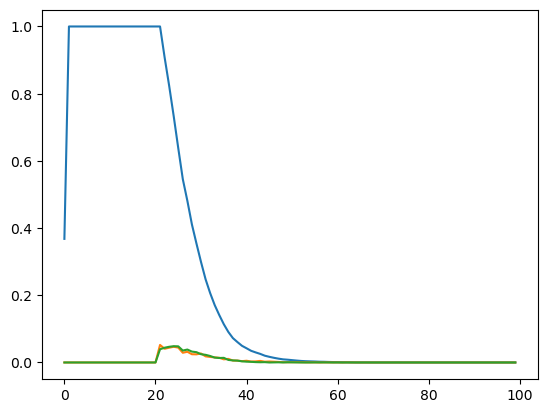

In [196]:
plt.plot(df.agg_survival)
plt.plot(df.i_c)
plt.plot(df.i_p)

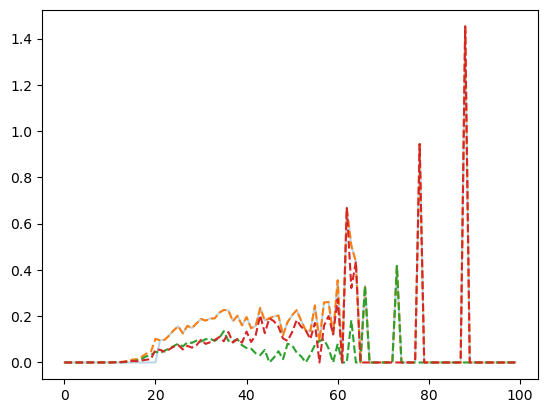

In [197]:
plt.plot(df[["hazard_agg"]], alpha=.3)
plt.plot(df["pass_hazard"]+df["collapse_hazard"], linestyle="--")
plt.plot(df["pass_hazard"], linestyle="--")
plt.plot(df["collapse_hazard"], linestyle="--")
plt.show()

In [198]:
input_df

,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,collapse_event,pass_event,end_time
13002,2415,0,25,5.3177,5,6.0,False,False,False,False,False,True,False,0,False,True,True,False,False,5
13003,2415,5,25,5.4308,5,6.0,False,False,False,False,False,True,False,0,False,True,True,False,False,10
13004,2415,10,25,5.5839,5,6.0,False,False,False,False,False,True,False,0,False,True,True,False,False,15
13005,2415,15,25,0.5770,5,6.0,False,False,False,False,False,True,False,0,False,True,True,False,False,20
13006,2415,20,25,0.0000,5,6.0,False,False,False,False,False,True,False,0,False,True,True,True,False,24


In [199]:
preds

{'i_c': np.float64(0.18371041981917816),
 'i_p': np.float64(0.17845738417784107),
 'survived': np.float64(0.6378321960029808),
 'id': np.int64(2415),
 'tau_landmark': 20,
 'collapse': np.True_,
 'pass': np.False_,
 'steps': 5}

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


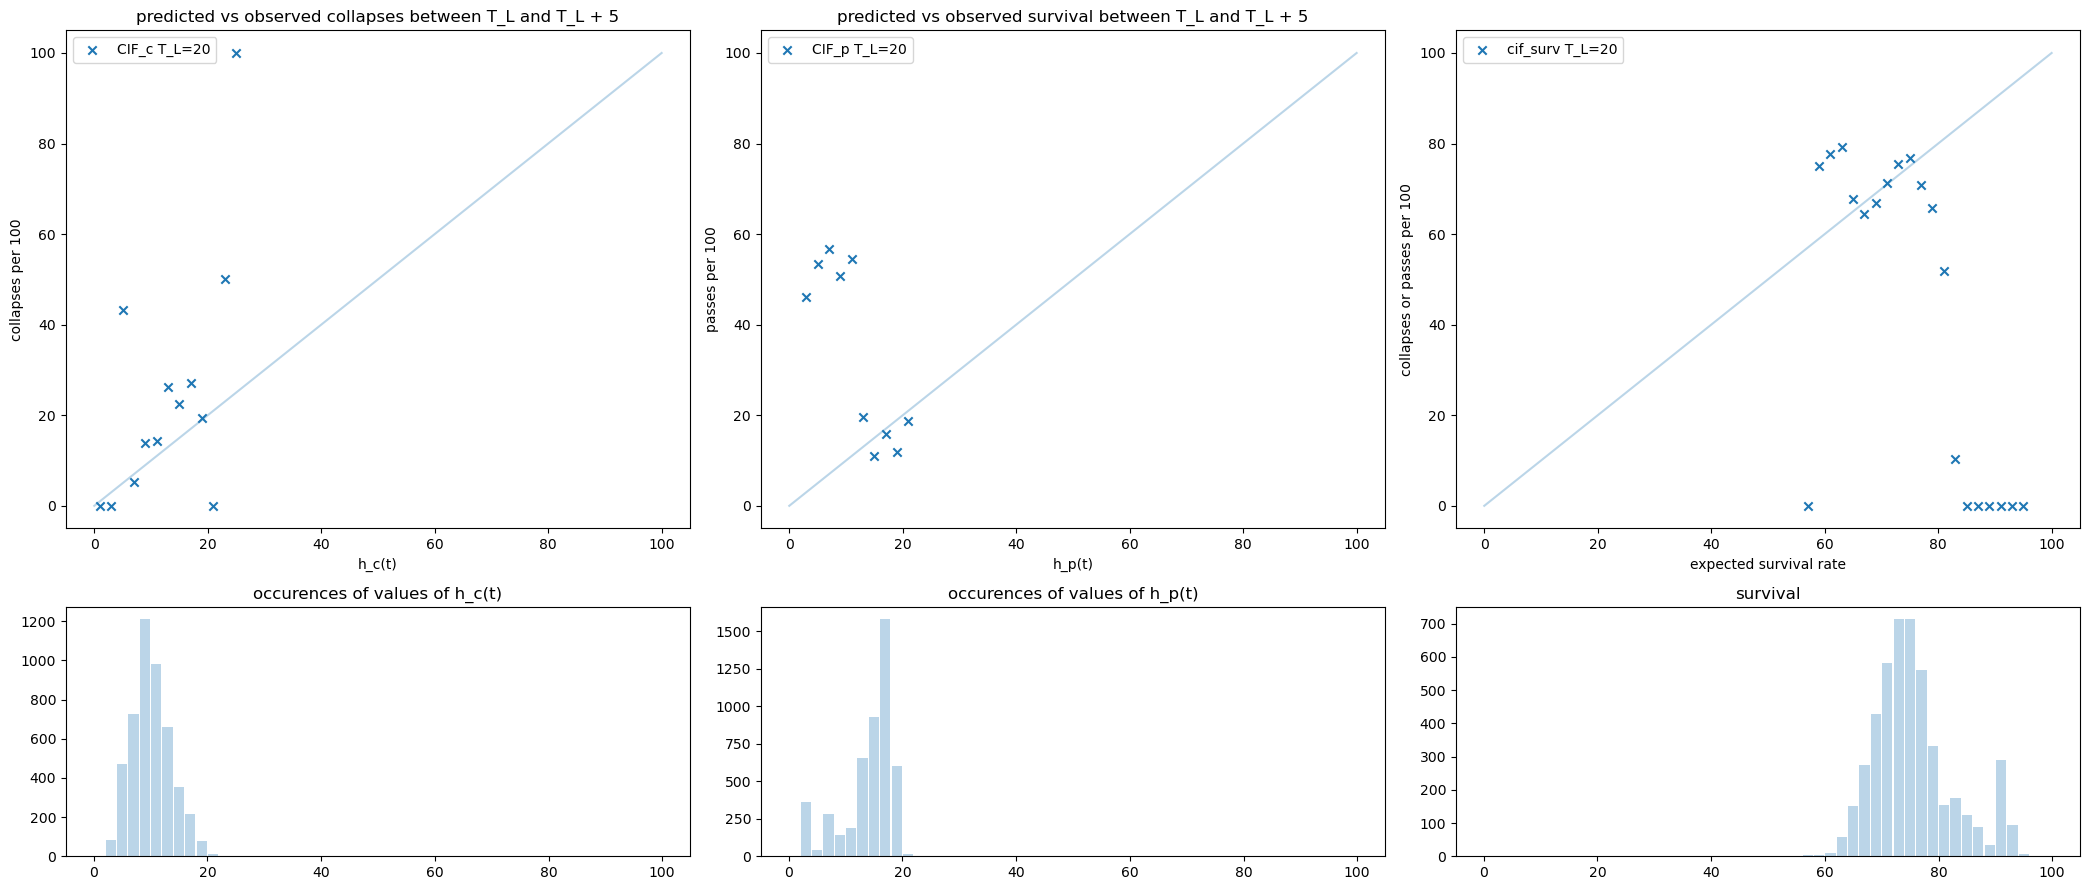

In [200]:

for tau_landmark in range(tl_min, tl_max, 5): 
    fig, ax = plt.subplots(2,3, figsize=(21,9), height_ratios=(2,1))
    ax[0,0].plot([0,100], [0,100], alpha=.3)
    ax[0,1].plot([0,100], [0,100], alpha=.3)
    ax[0,2].plot([0,100], [0,100], alpha=.3)
    x = np.arange(0,100, bucket_size)+bucket_size/2
    
    # ax[0,0].scatter(x, [np.mean(bucket)*100 for bucket in calib_c_dict[tau_landmark]], label=f"T_L={tau_landmark}")
    # ax[0,1].scatter(x, [np.mean(bucket)*100 for bucket in calib_p_dict[tau_landmark]], label=f"T_L={tau_landmark}")
    # ax[1,0].bar(x, [len(bucket) for bucket in calib_c_dict[tau_landmark]], label=tau_landmark, width = bucket_size*0.9, alpha=.3)
    # ax[1,1].bar(x, [len(bucket) for bucket in calib_p_dict[tau_landmark]], label=tau_landmark, width = bucket_size*0.9, alpha=.3)

    ax[0,0].scatter(x, [np.mean(bucket)*100 for bucket in calib_cifc_dict[tau_landmark]], marker="x", label=f"CIF_c T_L={tau_landmark}")
    ax[0,1].scatter(x, [np.mean(bucket)*100 for bucket in calib_cifp_dict[tau_landmark]], marker="x", label=f"CIF_p T_L={tau_landmark}")
    ax[1,0].bar(x, [len(bucket) for bucket in calib_cifc_dict[tau_landmark]], label=tau_landmark, width = bucket_size*0.9, alpha=.3)
    ax[1,1].bar(x, [len(bucket) for bucket in calib_cifp_dict[tau_landmark]], label=tau_landmark, width = bucket_size*0.9, alpha=.3)

    # ax[0,2].scatter(x, [np.mean(bucket)*100 for bucket in calib_surv_dict[tau_landmark]], label=f"surv T_L={tau_landmark}")
    # ax[1,2].bar(x, [len(bucket) for bucket in calib_surv_dict[tau_landmark]], label=tau_landmark, width = bucket_size*0.9, alpha=.3)
    ax[0,2].scatter(x, [np.mean(bucket)*100 for bucket in calib_cif_surv_dict[tau_landmark]], marker="x", label=f"cif_surv T_L={tau_landmark}")
    ax[1,2].bar(x, [len(bucket) for bucket in calib_cif_surv_dict[tau_landmark]], label=tau_landmark, width = bucket_size*0.9, alpha=.3)

    ax[0,0].set_title("predicted vs observed collapses between T_L and T_L + 5")
    ax[0,1].set_title("predicted vs observed passes between T_L and T_L + 5")
    ax[0,1].set_title("predicted vs observed survival between T_L and T_L + 5")
    ax[0,0].set_xlabel("h_c(t)")
    ax[0,1].set_xlabel("h_p(t)")
    ax[0,2].set_xlabel("expected survival rate")
    ax[0,0].set_ylabel("collapses per 100")
    ax[0,1].set_ylabel("passes per 100")
    ax[0,2].set_ylabel("collapses or passes per 100")
    ax[1,0].set_title("occurences of values of h_c(t)")
    ax[1,1].set_title("occurences of values of h_p(t)")
    ax[1,2].set_title("survival")
    fig.tight_layout()
    # ax[1,0].set_ylim(0,100)
    # ax[1,1].set_ylim(0,100)
    ax[0,0].legend()
    ax[0,1].legend()
    ax[0,2].legend()
    plt.show()

In [202]:
preds_df = pd.DataFrame(pred_list)

In [229]:
preds_df.head()

,i_c,i_p,survived,id,tau_landmark,collapse,pass,steps
0,0.0789,0.1739,0.7472,8199,20,False,True,5
1,0.1233,0.1686,0.7081,7932,20,False,False,5
2,0.1007,0.1434,0.7559,347,20,False,False,5
3,0.0738,0.1396,0.7866,5608,20,False,False,5
4,0.0873,0.1689,0.7439,3406,20,False,False,5


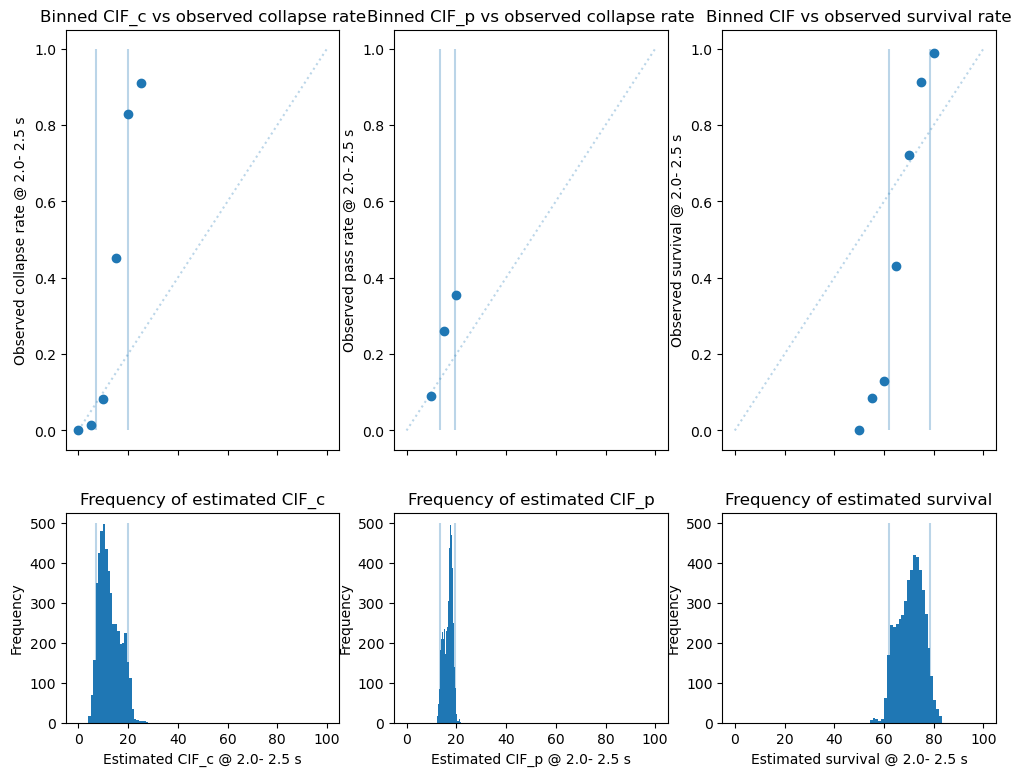

In [243]:
bs=5
fig, ax = plt.subplots(2,3, figsize=(12,9), height_ratios=(2,1), sharex=True)
ax[0,0].plot([0,100], [0,1], alpha=.3, linestyle=":")
ax[0,1].plot([0,100], [0,1], alpha=.3, linestyle=":")
ax[0,2].plot([0,100], [0,1], alpha=.3, linestyle=":")

cgrps = preds_df[["collapse"]].groupby((preds_df.i_c*100)//bs).mean().reset_index()
ax[0,0].scatter(cgrps["i_c"]*bs, cgrps["collapse"])

((preds_df.i_c*100)).plot.hist(bins=25, ax=ax[1,0])

pgrps = preds_df[["pass"]].groupby((preds_df.i_p*100)//bs).mean().reset_index()
ax[0,1].scatter(pgrps["i_p"]*bs, pgrps["pass"])

((preds_df.i_p*100)).plot.hist(bins=25, ax=ax[1,1])

sgrps = (~preds_df["collapse"] & ~preds_df["pass"]).groupby((preds_df["survived"]*100)//bs).mean().reset_index()
ax[0,2].scatter( sgrps["survived"]*bs, sgrps[0])

((preds_df.survived*100)).plot.hist(bins=25, ax=ax[1,2])

ax[0,0].set_title("Binned CIF_c vs observed collapse rate")
ax[0,1].set_title("Binned CIF_p vs observed collapse rate")
ax[0,2].set_title("Binned CIF vs observed survival rate")

ax[0,0].set_xlabel("Estimated CIF_c @ 2.0- 2.5 s")
ax[0,1].set_xlabel("Estimated CIF_p @ 2.0- 2.5 s")
ax[0,2].set_xlabel("Estimated CIF @ 2.0- 2.5 s")

ax[0,0].set_ylabel("Observed collapse rate @ 2.0- 2.5 s")
ax[0,1].set_ylabel("Observed pass rate @ 2.0- 2.5 s")
ax[0,2].set_ylabel("Observed survival @ 2.0- 2.5 s")

ax[1,0].set_xlabel("Estimated CIF_c @ 2.0- 2.5 s")
ax[1,1].set_xlabel("Estimated CIF_p @ 2.0- 2.5 s")
ax[1,2].set_xlabel("Estimated survival @ 2.0- 2.5 s")

ax[1,0].set_title("Frequency of estimated CIF_c")
ax[1,1].set_title("Frequency of estimated CIF_p")
ax[1,2].set_title("Frequency of estimated survival")
ax[0,0].vlines(preds_df.i_c.quantile([0.05, 0.95]).values*100, ymin = 0, ymax = 1, alpha=.3)
ax[0,1].vlines(preds_df.i_p.quantile([0.05, 0.95]).values*100, ymin = 0, ymax = 1, alpha=.3)
ax[0,2].vlines(preds_df.survived.quantile([0.05, 0.95]).values*100, ymin = 0, ymax = 1, alpha=.3)
ax[1,0].vlines(preds_df.i_c.quantile([0.05, 0.95]).values*100, ymin = 0, ymax = 500, alpha=.3)
ax[1,1].vlines(preds_df.i_p.quantile([0.05, 0.95]).values*100, ymin = 0, ymax = 500, alpha=.3)
ax[1,2].vlines(preds_df.survived.quantile([0.05, 0.95]).values*100, ymin = 0, ymax = 500, alpha=.3)
plt.show()